## Model for calculating kappa coefficient

This notebook is used to calculate the kappa coefficient to compare the svm model and the random forest model. The difference with the other full classification model is that only the labels originally mark as 'w', 'n' and 'r' are used. The other labels are not taken into account.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(splitData)

2023-07-14 14:52:18.049645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 14:52:18.125255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 14:52:19.301561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/Kappa/../Library/splitData.py'>

#### Preparation of the data

In [2]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_artifacts_free.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df = df[df['day']== 2]
df['breed'] = df['mouse'].apply(lambda x: breedManip.getBreedIndex(breedManip.getBreedOfMouse(x)))

In [4]:
# keep only the rawState with the value n,r,w
df = df[df['rawState'].isin(['n','r','w'])]

In [5]:
df.head()

,Unnamed: 0,rawState,state,EEGv,EMGv,epoch,day,spectral_flatness,spectral_centroid,spectral_entropy,...,EMGv_max100,EEGv_log,EMGv_log,bias,EEGv^2,EEGv^3,EMGv^2,EMGv^3,mouse,breed
42018,43200,w,w,2.561793e-09,2.476193e-10,43200,2,0.156645,15.654199,-6.416485,...,6.798730e-10,-19.782559,-22.119129,1,6.562781e-18,1.681248e-26,6.131530e-20,1.518285e-29,09003,34
42019,43201,w,w,2.890715e-09,1.768662e-10,43201,2,0.146992,15.432471,-5.647920,...,6.798730e-10,-19.661762,-22.455627,1,8.356233e-18,2.415549e-26,3.128167e-20,5.532671e-30,09003,34
42020,43202,w,w,2.657057e-09,1.719997e-10,43202,2,0.096660,11.455600,-5.618493,...,6.798730e-10,-19.746047,-22.483528,1,7.059955e-18,1.875871e-26,2.958391e-20,5.088426e-30,09003,34
42021,43203,w,w,3.102465e-09,1.463278e-10,43203,2,0.085641,10.517584,-5.388146,...,6.798730e-10,-19.591069,-22.645172,1,9.625289e-18,2.986212e-26,2.141181e-20,3.133143e-30,09003,34
42022,43204,w,w,3.150835e-09,1.709445e-10,43204,2,0.098589,10.449326,-5.478330,...,6.798730e-10,-19.575598,-22.489682,1,9.927761e-18,3.128074e-26,2.922202e-20,4.995344e-30,09003,34


In [6]:
selected_breeds = breedManip.selectAllBreedsOfSizeNOrMore(4)
id_selected_breeds = [breedManip.getBreedIndex(b) for b in selected_breeds]
df = df[df['breed'].isin(id_selected_breeds)]

In [7]:
df_train, df_test = splitData.split_data_breeds(df, 30)

In [8]:
df_train = df_train.drop(columns=['mouse'])
df_test = df_test.drop(columns=['mouse'])
df_train = df_train.drop(columns=['breed'])
df_test = df_test.drop(columns=['breed'])

In [9]:
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

#### Training of the model

In [10]:
rfc = RandomForestClassifier(random_state=13, class_weight="balanced", n_jobs=-1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [11]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/rfc_kappa.pkl', 'wb') as f:
    pickle.dump(rfc, f)

[[266248   1185   7859]
 [  8240  27741   2091]
 [ 14935   1171 430298]]


              precision    recall  f1-score   support

           n       0.92      0.97      0.94    275292
           r       0.92      0.73      0.81     38072
           w       0.98      0.96      0.97    446404

    accuracy                           0.95    759768
   macro avg       0.94      0.89      0.91    759768
weighted avg       0.95      0.95      0.95    759768



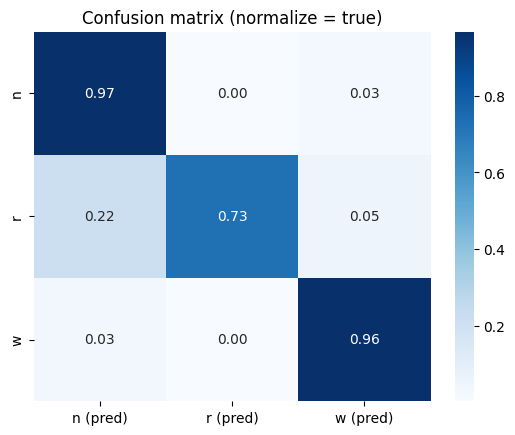

In [12]:
test = np.argmax(y_test, axis=1)
pred = np.argmax(y_pred, axis=1)

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')


print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()